# Using LittleVGG for EMotion Detection

### Training Emotion Detector

In [32]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.layers.advanced_activations import ELU
import os

In [33]:
num_classes = 6
img_rows,img_cols = 48,48
batch_size = 32

train_data_dir = './fer2013/train'
validation_data_dir = './fer2013/validation'

#let's do some data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 30,
                                  shear_range = 0.3,
                                  zoom_range = 0.3,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator  = train_datagen.flow_from_directory(train_data_dir,
                                                    color_mode = 'grayscale',
                                                    target_size =(img_rows,img_cols),
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                             color_mode = 'grayscale',
                                                             target_size = (img_rows,img_cols),
                                                             batch_size = batch_size,
                                                             class_mode = 'categorical',
                                                             shuffle = True)

Found 28273 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


## Creating Model

In [40]:

model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #5: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_11 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)       

## Training the model


In [29]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Emotion_detection.h5",
                            monitor='val_loss',
                            mode = 'min',
                            save_best_only = True,
                            verbose = 1)

earlystop= EarlyStopping(monitor='val_loss',
                        min_delta = 0,
                        patience = 5,
                        verbose = 1,
                        restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor = 0.2,
                             patience = 5,
                             verbose = 1,
                             min_delta=0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# Compiling
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.001),
             metrics=['accuracy'])

nb_train_samples = 28273
nb_validation_samples =3534
epochs = 50

history = model.fit_generator(train_generator,
                             steps_per_epoch=nb_train_samples//batch_size,
                             epochs = epochs,
                             callbacks = callbacks,
                             validation_data = validation_generator,
                             validation_steps=nb_validation_samples//batch_size)

NameError: name 'train_generator' is not defined

In [66]:


import  matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np

nb_train_samples = 28273  
nb_validation_samples = 3534

# we need to recreate our validation generator with shuffle = false

validation_generator = validation_datagen.flow_from_directory(
validation_data_dir,
color_mode='grayscale',
target_size = (img_rows,img_cols),
batch_size = batch_size,
class_mode='categorical',
shuffle = False)

class_labels = validation_generator.class_indices # it gives the classes labels
# {'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}
class_labels = {v:k for k, v in class_labels.items()}
classes = list(class_labels.values())
print("Class labels are",class_labels)

print("Classes are",classes)



Found 3534 images belonging to 6 classes.
Class labels are {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'}
Classes are ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


C:\Users\Sumit\anaconda3\envs\cv\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(3534, 6)
[[2.16823071e-01 1.06542654e-01 1.55494325e-02 3.70724261e-01
  2.79020876e-01 1.13396244e-02]
 [9.12040293e-01 7.03974888e-02 5.12215542e-03 7.83300784e-04
  5.53372130e-03 6.12307200e-03]
 [6.51892781e-01 1.50442481e-01 2.82125007e-02 3.24218012e-02
  1.25886247e-01 1.11441873e-02]
 ...
 [1.32296272e-02 1.24650128e-01 7.54520996e-03 5.09491377e-03
  3.56036797e-03 8.45919728e-01]
 [3.32851522e-02 1.67721659e-01 1.06800431e-02 2.41453007e-01
  7.81687945e-02 4.68691349e-01]
 [6.24770746e-02 3.07334542e-01 3.19395550e-02 1.39449500e-02
  2.28791535e-02 5.61424673e-01]]
(3534,)
[3 0 0 ... 5 5 5]
Confusion Matrix
[[229  29  27  71 123  12]
 [ 90  89  30  65 175  79]
 [ 11  14 767  29  39  19]
 [ 95  40 153 121 155  62]
 [ 35  20  35 134 359  11]
 [ 15  37  30  14  13 307]]
Classification report
target names are: ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
              precision    recall  f1-score   support

       Angry       0.48      0.47      0.47       491
  

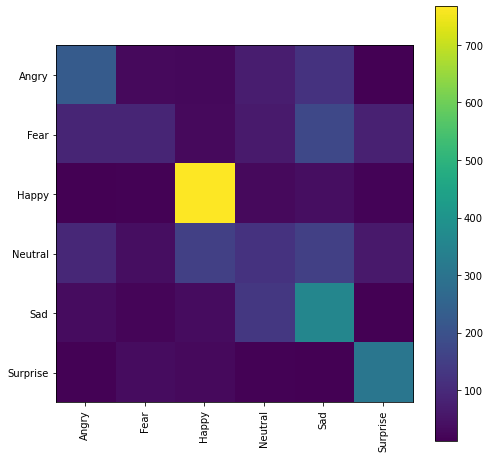

In [67]:
## Cnfusion matrix and classification report
Y_pred = model.predict_generator(validation_generator,nb_validation_samples // batch_size+1)
print(Y_pred.shape)
print(Y_pred)

y_pred = np.argmax(Y_pred,axis=1) #np.argmax Returns the indices of the maximum values along an axis.
print(y_pred.shape)
print(y_pred)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes,y_pred))
print('Classification report')
target_names = list(class_labels.values())
print("target names are:",target_names)
print(classification_report(validation_generator.classes,y_pred,target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes,y_pred)

plt.imshow(cnf_matrix,interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
print("Tickmarkks:",tick_marks)

_ = plt.xticks(tick_marks,classes,rotation=90)
_ = plt.yticks(tick_marks,classes)

In [68]:
from keras.models import load_model

model = load_model("./Emotion_detection.h5")

## Testing on validation images 

In [70]:
from keras.models import load_model
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re
def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 150, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predicted - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height),grayscale=True), final_path, path_class

# dimensions of our images
img_width, img_height = 48, 48

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 10):
    path = './fer2013/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

## TEst on single image

In [71]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import img_to_array


face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')


def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:  #x,y,w,h are bounding rectangles around face
    #x,y are the top left axes and w and h are width and hheight respectivel"""
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

img = cv2.imread("sumit.jpg")
rects, faces, image = face_detector(img)

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    preds = model.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    
cv2.imshow("Emotion Detector", image)
cv2.waitKey(0)

cv2.destroyAllWindows()

<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-71-ce6a8148a990>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():


## Making this on webcam

In [73]:
import cv2
import numpy as np
from time import sleep
from keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]

    try:
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
    except:
        return (x,w,y,h), np.zeros((48,48), np.uint8), img
    return (x,w,y,h), roi_gray, img


cap = cv2.VideoCapture(0)


while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = model.predict(roi)[0]
        label = class_labels[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-73-9c87e821f8d6>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():


In [ ]:
! git add Emotion_detection.h5 Emotion_detection.ipynb
! git commit -m "15:56/15-05-2021"
! git push origin main